# Titanic Survival Prediction (Score: 0.8 Top 20%)
from Kaggle: https://www.kaggle.com/c/titanic

Challenge Description:

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Table of Content
### 1. Explore the Dataset
### 2. Handle Numeric Features
### 3. Handle Categorical Features
### 4. Model Selection and Evaluation
### 5. Result

In the following content, the overall summary for the training dataset will be discussed first to have basic understanding of the data. Next, each feature in the dataset will be examined to see whether it is suitable to be included in the predictive model. Lastly, proper model will be selected and will go through evaluation to ensure that the model can offer accuracy as high as possible. Eventually, the finalized model will be utilized to predict the result.

## 1. Explore the Dataset


In [1]:
# import needed packages
import pandas as pd
import numpy as np
import copy
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

train_df=pd.read_csv('train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The feautures can be classified into:
1. Categorical Data: PassengerId, Survived, Pclass, Name, Sex, Ticket, Cabin, and Embarked
2. Numeric Data: Age, SibSp, Parch, and Fare 

In [2]:
# Generate description for numeric features
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
# Generate description for categorical features
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Yasbeck, Mr. Antoni",male,1601,G6,S
freq,1,577,7,4,644


The above tables offer the following observations:
1. For the overall records, the survival rate is 38%
2. Most passengers (>=50%) came without siblings, parents, or children.
3. Over 75% of passengers are under 40s.
4. Age, Embarked, and Cabin have empty values, which may influence the prediction.
5. PassengerId, Tickets, Name, and Cabin may be dropped because they contain too many unique values.
6. Most passengers (>=75%) paid for less than $40 for the trip.

## 2. Handle Numeric Data

The numeric factors (Age, SibSp, Parch, and Fare) in the dataset will be examined to check whether they are suitable for prediction. Also, I may modify or create new features.

### Age

In order to check the relationship between "Age"(numeric) and "Survived"(categorical), t-test is used to check whether Age values display siginificant difference between Survived and non-Survived passengers. Before running t-test, F-test have been proceeded to confirm the homogeneity of variance, which is a crucial assumption for running t-test. The resultant P-Value is higher than 0.05, meaning that the data fulfills homogeneity of variance. Therefore, t-test can be manipulated directly. 

Please kindly refer to my R script file for F-test result.
<img src="Age_VS_Survived_F_test_Result.png" alt="Drawing" style="width: 500px;"/>



In [4]:
# t-test to compare the average ages of survived passengers and non-survived ones
t_score, p=stats.ttest_ind(train_df.dropna().loc[train_df["Survived"]==0,"Age"],train_df.dropna().loc[train_df["Survived"]==1,"Age"])

print("======T-Test======")

print("H0: No siginificant difference in Age between Survived and non-Survived")
print("Ha: There is siginificant difference in Age between Survived and non-Survived")
print("T-Score: %.3f" %t_score)
print("P-Value: %.3f" %p)
if p>0.05:
    print("Cannot reject null hypothesis.")
else:
    print("Can reject null hypothesis.")

print("==================")

    

======T-Test======
H0: No siginificant difference in Age between Survived and non-Survived
Ha: There is siginificant difference in Age between Survived and non-Survived
T-Score: 3.534
P-Value: 0.001
Can reject null hypothesis.


As shown above, null hypothesis can be rejected to believe that there is difference between the average ages of Survived and non-Survived people. Therefore, "Age" can be included in prediction.

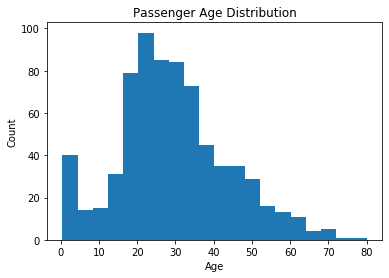

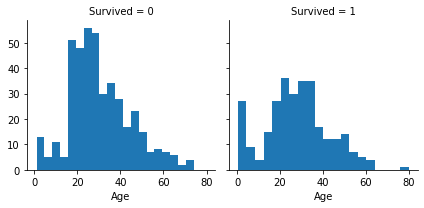

In [5]:
# visualize the distribution of ages
plt.title("Passenger Age Distribution")
plt.hist(x=train_df['Age'].dropna(), bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

The above graphs regarding "Age" offer the following observations:
1. Large number of passengers are between 20s to 40s
2. Passengers younger than 20s have higher survival rate.
3. Oldest people (80s) survived. It may be explained by the fact that older people received a lot of caring at that time so that when the disaster happened, they were not ignored.

The observations give the idea that "Age" may be cut into different categories for prediction.

### Parch and SibSp

For "Parch" and "SibSp", because those two factors display 0 in most records (>=50%), it may be better to convert them into categorical data.

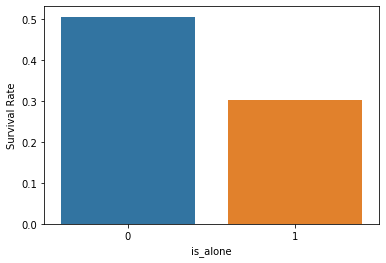

In [6]:
is_alone=[]

# merge Parch and SibSp into "is_alone" feature
# check whether the passanger came alone
for x in range(len(train_df)):
    if train_df.iloc[x,list(train_df.columns).index("Parch")]==0 and train_df.iloc[x,list(train_df.columns).index("SibSp")]==0:
        is_alone.append(1)
    else:
        is_alone.append(0)
        
train_df["is_alone"]=is_alone

# calculate survival rate for each group
group_df=train_df[["is_alone","Survived"]].groupby("is_alone", as_index=False).agg(np.mean)

# visualize the result
sns.barplot(x="is_alone", y="Survived", data=group_df)
plt.ylabel("Survival Rate")
plt.show()


As shown above, there is clear difference in survival rate between being alone and not. This fact supports that I can contain this feature in the prediction.

### Fare

The last numeric factors to be examined is "Fare". Let's first take a look at its distribution.

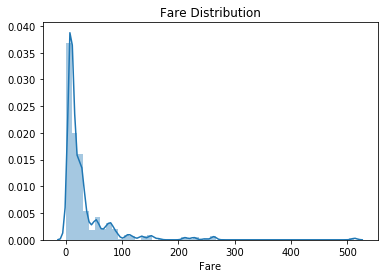

In [7]:
plt.title("Fare Distribution")
sns.distplot(train_df['Fare'])
plt.show()

As observed in the beginning (Most passengers (>=75%) paid for less than $40 for the trip.), the distribution of Fare is highly skewed. Skewedness may be fixed by implementing log scale.

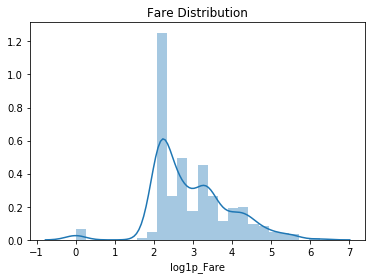

In [8]:
# turn data into log scale
train_df['log1p_Fare']=np.log1p(train_df['Fare'])
plt.title("Fare Distribution")
sns.distplot(train_df['log1p_Fare'])
plt.show()

By using log scale, the problem of skewedness has been relieved. Then, the data can be allocated into different groups to compare survival rates.

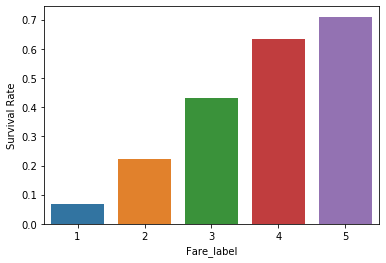

In [9]:
# classify "Fare" into 5 groups. 1<2<3<4<5
train_df["Fare_label"]=pd.cut(train_df['log1p_Fare'],5, labels=[1, 2, 3, 4, 5])

# calculate survival rate for each group
group_df=train_df[["Fare_label","Survived"]].groupby("Fare_label", as_index=False).agg(np.mean)

# visualize the result
sns.barplot(x="Fare_label", y="Survived", data=group_df)
plt.ylabel("Survival Rate")
plt.show()

The above graph supports that passengers who paid higher possess higher survival rate. Hence, the "Fare" feature could be included in the prediction.

## 3. Handle Categorical Data

### Sex

In [10]:
train_df[["Sex","Survived"]].groupby('Sex', as_index=False).agg(np.mean)

,Sex,Survived
0,female,0.742038
1,male,0.188908


The table displays strong difference. Female passengers acquire much higher survival rate than males. This could be attributed to the fact that the evacuation plan at that time was to let children and women leave the boat first. This feature could be crucial for the prediction.

### Pclass

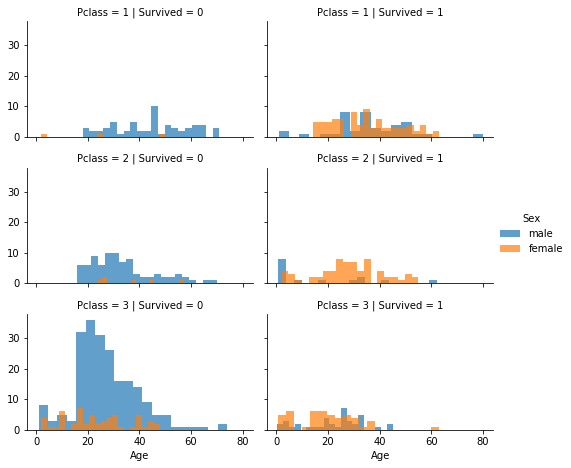

In [11]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', hue="Sex", height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.7, bins=20)
grid.add_legend();
plt.show()

The above graphs offer the following observations:
1. The survival rate in Pclass 3 is significantly high. This can be explained by the higher percentage of male passengers (the fact proved previously).
2. Young child in Pclass 2 all survived.
3. Pclass 1 has higher survival rate.
4. Each Pclass has different age distribution.
5. Pclass has relaionship with age and sex distribution, which have been proved to have certain level of correlation with survival rate.

Based on the observations above, "Pclass" would be considered in the prediction.

### Embarked

"Embarked" is examined by using the same graphs.

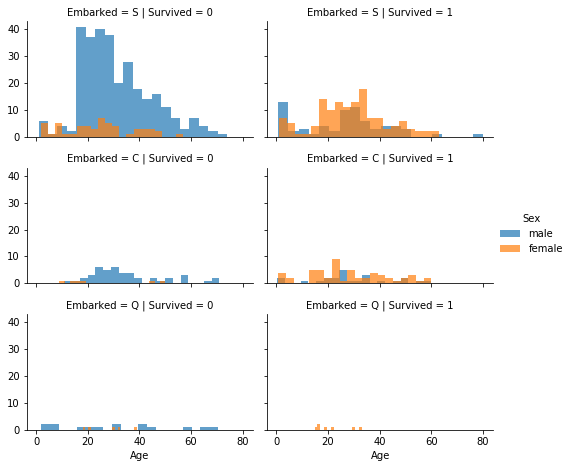

In [12]:
grid = sns.FacetGrid(train_df, col='Survived', row='Embarked', hue="Sex", height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.7,  bins=20)
grid.add_legend();
plt.show()

In [13]:
train_df.groupby("Embarked", as_index=False)["PassengerId"].agg("count")

,Embarked,PassengerId
0,C,168
1,Q,77
2,S,644


According to the graphs above, the comparison among "Embarked", "Age", and "Sex" demonstrates the same phenomenon with "Pclass" (most people embarked from a certain portion, and female's survival rate is much higher than male's). However, the number of passengers (>70%) who emarked from port S is significantly larger than the numbers from the other two ports. Therefore, this feature may not be distinguishable enough for modeling. 

"Embarked" may not be included in the model training.

### Name, Ticket, Cabin, and PassengerId

Cabin, Name, Ticket, and PassengerId may be dropped for the following reasons:
1. Cabin values are extremely incomplete and have many duplicates across the sample. 
2. Name, PassengerId, and Ticket values are almost unique for each individual. It is hard to observe pattern when there are too many unique values.

## 4. Model Selection and Evaluation

So far, the features that are confirmed to be used are "Age", "Fare", "is_alone", "Sex", "Pclass".

Because the target feature is categorical (Boolean values), Logistic Regression and Random Forest Regression may be suitable models for prediction.

Logistic Regression is a model specialized in dealing with binary variables. In this case, our result would need to be 0 or 1. Therefore, logistic Regression may be a useful model to predict the result.

On the other hand, Random Forest Regression is the classification and regression models based on the idea of decision tree. Random Forest Regression would sensitive to the change of each feature and operate by running several prediction processes to have the most average result. Hence, as the target variable is categorical, it would be helpful to use Random Forest Regression to conduct classification. 

In [14]:
# extract numeric features
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
train_x = train_df[["Age",'log1p_Fare']].copy()
train_y = train_df["Survived"]
imputer = SimpleImputer(strategy = 'median') # fill null with median values
imputer.fit(train_x)
train_x=imputer.transform(train_x)
train_x = MMEncoder.fit_transform(train_x) # Standardized features
train_x = pd.DataFrame(train_x, columns = ['Age','Fare'])

# extract categorical features
categorical = train_df[['is_alone','Sex','Pclass']].copy()
categorical['Sex'] = LEncoder.fit_transform(categorical['Sex']) # encoding labels

# merge features
train_x = pd.concat([train_x,categorical],axis=1)
# train the model
estimator1 = RandomForestClassifier()
estimator2 = LogisticRegression(max_iter=1000)
accuracy1 = cross_val_score(estimator1, train_x, train_y, cv=5).mean()
accuracy2 = cross_val_score(estimator2, train_x, train_y, cv=5).mean()

print("Random Forest Accuracy: %f" %accuracy1)
print("Logistic Regression Accuracy: %f" %accuracy2)

Random Forest Accuracy: 0.814858
Logistic Regression Accuracy: 0.783378


As previous observation has suggested that Age values may be able to categorized, we may categorize the values and see if this action can improve the accuracy of the model.

In [15]:
temp_x=train_x.copy()
temp_x.drop('Age', inplace = True, axis = 1)
temp_x['Age_segment']=pd.cut(train_x['Age'],bins=4,labels=[1,2,3,4])

accuracy1 = cross_val_score(estimator1, temp_x, train_y, cv=5).mean()
accuracy2 = cross_val_score(estimator2, temp_x, train_y, cv=5).mean()

print("Random Forest Accuracy: %f" %accuracy1)
print("Logistic Regression Accuracy: %f" %accuracy2)


Random Forest Accuracy: 0.802517
Logistic Regression Accuracy: 0.775570


As shown, the accuracy does not appear higher when Age values are categorized. Also, Random Forest generates higher accuracy than Logistic Regression. Hence, Random Forest will be used as the main model to predict.

But before proceeding to the final prediction, it may be a good idea to testify importance of each original features in the dataset. It may help identify the features that have been abandoned but possess strong importance in the prediction process.

In [16]:
# re-input and re-organized the training dataset
temp_x = pd.read_csv('train.csv')
for c in temp_x.columns:
    temp_x[c] = temp_x[c].fillna(-1)
    
    # encoding categorical labels
    if temp_x[c].dtype == 'object':
        temp_x[c] = LEncoder.fit_transform(list(temp_x[c].values))
    temp_x[c] = MMEncoder.fit_transform(temp_x[c].values.reshape(-1, 1))
    
temp_x.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.000000,0.0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.001124,1.0,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,0.002247,1.0,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.003371,1.0,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,0.004494,0.0,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [17]:
# put the whole dataset into the Random Forest Model 
estimator = RandomForestClassifier()
estimator.fit(temp_x.values, train_y)
feats = pd.Series(data=estimator.feature_importances_, index=temp_x.columns) # display their importance
feats = feats.sort_values(ascending=False)
feats

Survived       0.718166
Sex            0.113541
Fare           0.029443
Ticket         0.028657
Cabin          0.028066
Pclass         0.025050
Name           0.015016
Age            0.012879
PassengerId    0.011768
Parch          0.007686
SibSp          0.005161
Embarked       0.004567
dtype: float64

As seen, "Ticket" ranks high in terms of feature importance. Adding "Ticket" into the model may actually improve the accuracy.

In [18]:
# test adding "Ticket" in the model
temp_x=train_x.copy()
temp_x['Ticket']=LEncoder.fit_transform(train_df['Ticket']) # encoding labels
accuracy1 = cross_val_score(estimator1, temp_x, train_y, cv=5).mean()
accuracy2 = cross_val_score(estimator2, temp_x, train_y, cv=5).mean()

print("Random Forest Accuracy: %f" %accuracy1)
print("Logistic Regression Accuracy: %f" %accuracy2)

Random Forest Accuracy: 0.835051
Logistic Regression Accuracy: 0.791250


The accuracy has been higher. The ultimate features used in the model are "Age", "Fare", "is_alone", "Sex", "Pclass", and "Ticket".

## Result

In [19]:
# input the test dataset and preprocess it
test_df = pd.read_csv('test.csv')

is_alone=[]

# check whether the passanger came alone
for x in range(len(test_df)):
    if test_df.iloc[x,list(test_df.columns).index("Parch")]==0 and test_df.iloc[x,list(test_df.columns).index("SibSp")]==0:
        is_alone.append(1)
    else:
        is_alone.append(0)
        
test_df["is_alone"]=is_alone

test_df['log1p_Fare']=np.log1p(test_df['Fare'])

train_x['Ticket'] = LEncoder.fit_transform(train_df['Ticket']) # add Ticket values into our formal training dataset

# extract numeric features
test_x = test_df[["Age",'log1p_Fare']].copy()
imputer = SimpleImputer(strategy = 'median') # replace null with median values
imputer.fit(test_x)
test_x=imputer.transform(test_x)
MMEncoder = MinMaxScaler() 
test_x = MMEncoder.fit_transform(test_x) # Standardized features
test_x = pd.DataFrame(test_x, columns = ['Age','Fare'])

# extract categorical features
categorical = test_df[['is_alone','Sex','Pclass','Ticket']].copy()
categorical['Sex'] = LEncoder.fit_transform(categorical['Sex']) # encoding labels
categorical['Ticket'] = LEncoder.fit_transform(categorical['Ticket']) # encoding labels


# merge features
test_x = pd.concat([test_x,categorical],axis=1)

# proceed prediction
RFC= RandomForestClassifier()
RFC.fit(train_x, train_y)
RFC_pred = RFC.predict(test_x)


In [20]:
result_df = pd.DataFrame()
result_df['PassengerId'] = test_df['PassengerId']
result_df['Survived'] = RFC_pred
result_df.to_csv('result.csv' , index = False)
result_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Result: Score 0.8 Top 20%